**Importer les librairies**

In [ ]:
import os
import random
import json
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


**Monter Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**ÉTAPE 1: Définir le chemin du dataset**

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/Projet_Machine_Learning/Rice/Rice"


**Vérification**

In [ ]:
os.listdir(DATASET_PATH)


['Jasmine', 'Ipsala', 'Karacadag', 'Basmati', 'Arborio']

# **ÉTAPE 2: Exploration du dataset (ANALYSE)**

**Lister les classes**

In [ ]:
classes = os.listdir(DATASET_PATH)
print("Classes :", classes)
print("Nombre de classes :", len(classes))


Classes : ['Jasmine', 'Ipsala', 'Karacadag', 'Basmati', 'Arborio']
Nombre de classes : 5


**Compter les images par classe**

In [ ]:
nb_images = {}

for cls in classes:
    path = os.path.join(DATASET_PATH, cls)
    nb_images[cls] = len(os.listdir(path))
    print(f"{cls} : {nb_images[cls]} images")


Jasmine : 100 images
Ipsala : 100 images
Karacadag : 100 images
Basmati : 100 images
Arborio : 100 images


**Visualiser des images**

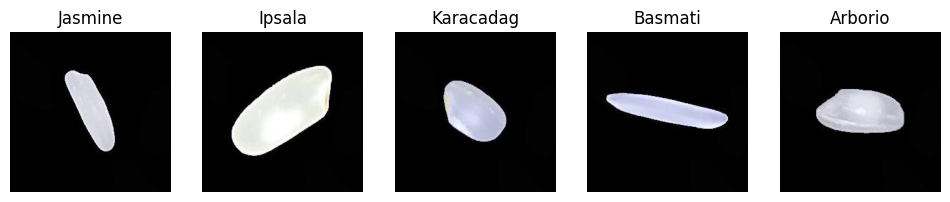

In [ ]:
plt.figure(figsize=(12,6))

for i, cls in enumerate(classes):
    img_name = random.choice(os.listdir(os.path.join(DATASET_PATH, cls)))
    img_path = os.path.join(DATASET_PATH, cls, img_name)
    img = Image.open(img_path)

    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.show()

# **ÉTAPE 3: Nettoyage des images corrompues**

In [ ]:
bad_images = []

for cls in classes:
    for img_name in os.listdir(os.path.join(DATASET_PATH, cls)):
        img_path = os.path.join(DATASET_PATH, cls, img_name)
        try:
            Image.open(img_path).verify()
        except:
            bad_images.append(img_path)

print("Images corrompues détectées :", len(bad_images))


Images corrompues détectées : 0


#**ÉTAPE 4 : Prétraitement des images**

**Paramètres globaux**

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


**Générateur avec augmentation de données (TRAIN + VAL)**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
    brigtness_range=[0.8, 1.2]
)


**Générateur d’entraînement**

In [ ]:
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)


Found 400 images belonging to 5 classes.


**Générateur de validation**

In [ ]:
val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 100 images belonging to 5 classes.


#**ÉTAPE 5 — Vérification des labels**

In [ ]:
class_indices = train_generator.class_indices
print(class_indices)


{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


**Sauvegarder les labels (IMPORTANT POUR L’API)**

In [ ]:
with open("class_names.json", "w") as f:
    json.dump(class_indices, f)


#**ÉTAPE 6: Visualiser les images après prétraitement**

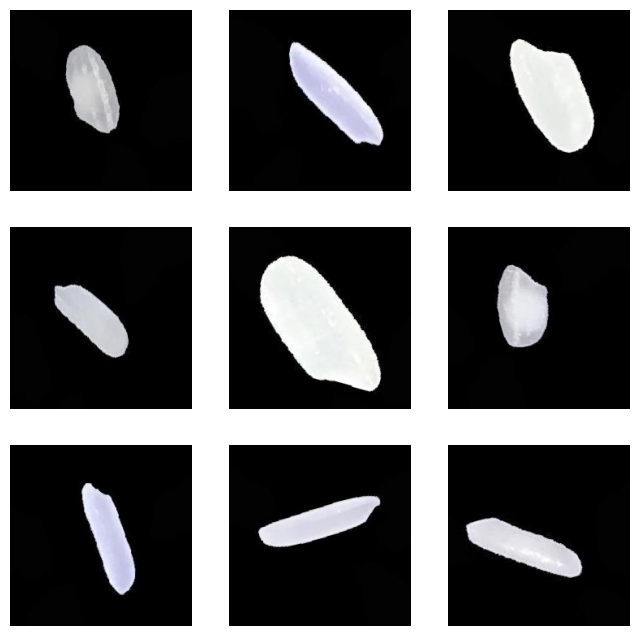

In [ ]:
images, labels = next(train_generator)

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.axis("off")

plt.show()


#**ÉTAPE 7 — Sauvegarde des données prétraitées**



In [ ]:
np.save("X_train_sample.npy", images)
np.save("y_train_sample.npy", labels)


#**La MODÉLISATION CNN avec Transfer Learning**

#**Modélisation avec MobileNetV2**

**Importations**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

**Paramètres**

In [ ]:
IMG_SIZE = (224, 224)
NUM_CLASSES = train_generator.num_classes


**Charger MobileNetV2 pré-entraîné**

In [ ]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Geler les couches convolutives**

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

**Ajouter les couches de classification**

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)


**Compiler le modèle**

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

**Résumé du modèle**

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#**Entraînement du modèle**

In [ ]:
EPOCHS = 20

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.2378 - loss: 1.8451 - val_accuracy: 0.5800 - val_loss: 1.2615
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 597ms/step - accuracy: 0.3579 - loss: 1.4061 - val_accuracy: 0.7800 - val_loss: 1.0539
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 489ms/step - accuracy: 0.4737 - loss: 1.1966 - val_accuracy: 0.8200 - val_loss: 0.9270
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 618ms/step - accuracy: 0.6431 - loss: 0.9928 - val_accuracy: 0.8200 - val_loss: 0.8336
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 517ms/step - accuracy: 0.6876 - loss: 0.8679 - val_accuracy: 0.8600 - val_loss: 0.7033
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 627ms/step - accuracy: 0.7595 - loss: 0.7205 - val_accuracy: 0.8700 - val_loss: 0.6538
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 527ms/step - accuracy: 0.8242 - loss: 0.6390 - val_accuracy: 0.8900 - val_loss: 0.6161
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 583ms/step - accuracy: 0.8459 - loss: 0.5790 - val_accuracy: 0.86

#**Évaluation des performances**

**Courbes Accuracy / Loss**

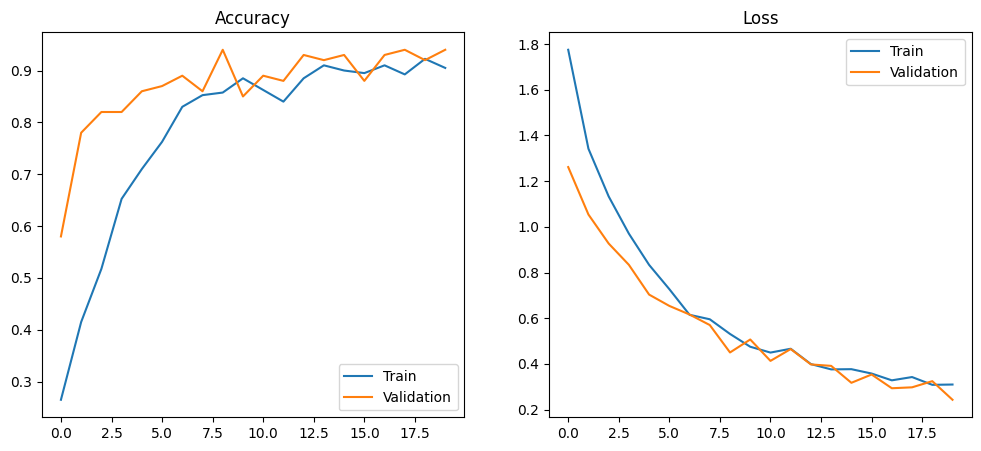

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.show()


**Matrice de confusion **

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


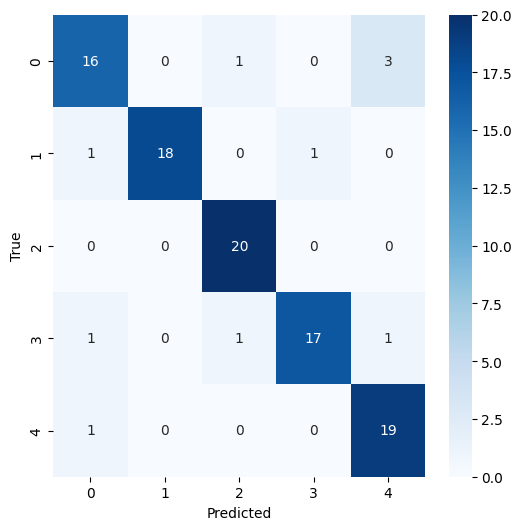

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        20
           1       1.00      0.90      0.95        20
           2       0.91      1.00      0.95        20
           3       0.94      0.85      0.89        20
           4       0.83      0.95      0.88        20

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred))


#**Sauvegarde du modèle**

In [ ]:
import os

# Défini le répertoire
model_save_dir = "/content/drive/MyDrive/Projet_Machine_Learning/model"

# Crée le répertoire s'il n'existe pas
os.makedirs(model_save_dir, exist_ok=True)

# Sauvegarde le modèle
model.save(os.path.join(model_save_dir, "rice_classification_mobilenet.keras"))

In [ ]:
import shutil
import os

source_model_path = "/content/drive/MyDrive/Projet_Machine_Learning/model/rice_classification_mobilenet.keras"
destination_dir = "/content/drive/MyDrive/Projet_Machine_Learning/api"

#  Crée le répertoire de destination s'il n'existe pas
os.makedirs(destination_dir, exist_ok=True)

# Defini le chemin complet du modèle copié
destination_model_path = os.path.join(destination_dir, os.path.basename(source_model_path))

# Copie le modèle
shutil.copy(source_model_path, destination_model_path)

print(f"Model copied from {source_model_path} to {destination_model_path}")

Model copied from /content/drive/MyDrive/Projet_Machine_Learning/model/rice_classification_mobilenet.keras to /content/drive/MyDrive/Projet_Machine_Learning/api/rice_classification_mobilenet.keras


In [ ]:
import shutil
import os

source_json_path = "/content/class_names.json"
destination_dir = "/content/drive/MyDrive/Projet_Machine_Learning/api"

# Crée le répertoire de destination s'il n'existe pas
os.makedirs(destination_dir, exist_ok=True)

# Défini le chemin complet du fichier JSON copié
destination_json_path = os.path.join(destination_dir, os.path.basename(source_json_path))

# Copie le fichier JSON
shutil.copy(source_json_path, destination_json_path)

print(f"JSON file copied from {source_json_path} to {destination_json_path}")

JSON file copied from /content/class_names.json to /content/drive/MyDrive/Projet_Machine_Learning/api/class_names.json


In [ ]:
import os

# Défini les packages utilisés dans le notebook
requirements = [
   "fastapi",
   "uvicorn",
   "tensorflow",
   "pillow",
   "numpy",
   "python-multipart"
]

# Défini le répertoire de destination
destination_dir = "/content/drive/MyDrive/Projet_Machine_Learning/api"

# S'assure que le répertoire existe
os.makedirs(destination_dir, exist_ok=True)

# Défini le chemin complet du fichier requirements.txt
requirements_path = os.path.join(destination_dir, "requirements.txt")

# Ecrit the exigences dans le fichier
with open(requirements_path, "w") as f:
    for req in requirements:
        f.write(req + "\n")

print(f"requirements.txt created at {requirements_path}")

requirements.txt created at /content/drive/MyDrive/Projet_Machine_Learning/api/requirements.txt
